# Multi-layer FNN on MNIST

This is MLP (784-X^W-10) on MNIST. SGD algorithm (lr=0.1) with 100 epoches.

 

In [1]:
import os, sys
import numpy as np
from matplotlib.pyplot import *
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import itertools


%matplotlib inline

In [2]:
""" Extract final stats from resman's diary file"""
def extract_num(lines0):

    valid_loss_str     = lines0[-5]
    valid_accuracy_str = lines0[-6]
    train_loss_str     = lines0[-8]
    train_accuracy_str = lines0[-9]
    run_time_str       = lines0[-10]

    valid_loss     = float(valid_loss_str.split( )[-1])
    valid_accuracy = float(valid_accuracy_str.split( )[-1])
    train_loss     = float(train_loss_str.split( )[-1])
    train_accuracy = float(train_accuracy_str.split( )[-1])
    run_time       = float(run_time_str.split( )[-1])
    
    return valid_loss, valid_accuracy, train_loss, train_accuracy, run_time

""" Extract number of total parameters for each net config from resman's diary file"""
def parse_num_params(line0):
    line_str = ''.join(lines0)
    idx = line_str.find("Total params")
    param_str = line_str[idx+14:idx+14+20] # 14 is the length of string "Total params: "
    param_num = param_str.split("\n")[0]
    return int(locale.atof(param_num))

#### Extract results from diary file

    1. Number of params
    2. Loss/Accuarcy for training/testing
    3. Runing time

In [19]:
results_dir = '../results/fnn_mnist_l2_ni'
       
depth = [1,2,3,4,5]
width = [50,100,200,400]
dim   = [0,10,50,100,200,300,350,375,400,425,450,475,500,525,550,575,600,625,650,675,700,725,750,775,800,850,900,1000,1250,1500]


########## 1. filename list of diary ########################
diary_names = []
for subdir, dirs, files in os.walk(results_dir):
    for file in files:
        if file == 'diary':
            fname = os.path.join(subdir, file)
            diary_names.append(fname)
            

########## 2. Construct stats (width, depth, dim) ##########
# acc_test_all : Tensor (width, depth, dim)
# num_param_all: Tensor (width, depth)
# acc_solved_all:  Tensor (width, depth)
# dim_solved_all:  Tensor (width, depth)
############################################################
nw, nd, nn= len(width), len(depth), len(dim)

acc_test_all  = np.zeros((len(width), len(depth), len(dim)))
num_param_all = np.zeros((len(width), len(depth)))
acc_solved_all = np.zeros((len(width), len(depth)))
dim_solved_all = np.zeros((len(width), len(depth)))

mode = 1         # {0: test loss, 1: test acc}
error_files = [] #  record the error file

# 2.1 construct acc_test_all and num_param_all
for id_w in range(len(width)):
    w = width[id_w]
    for id_ll in range(len(depth)):
        ll = depth[id_ll]
        for id_d in range(len(dim)):
            d = dim[id_d]
            
            # 2.1.1 Read the results, 
            for f in diary_names:
                if '_'+str(d)+'_'+str(ll)+'_'+str(w)+'/' in f:
                    # print "%d is in" % d + f
                    
                    with open(f,'r') as ff:
                        lines0 = ff.readlines()
                        try:
                            R = extract_num(lines0)
                            R = np.array(R)

                        except ValueError:
                            error_files.append((w,ll,d))
                            R = np.zeros(len(R))
                            print "Error. Can not read config: depth %d, width %d and dim %d." % (ll, w, d) 
                            # break
                            
                            
            # 2.1.2 Assign the results
            r = R[mode]  
            acc_test_all[id_w,id_ll,id_d]=r
            if d==0:
                num_param_all[id_w,id_ll]=parse_num_params(lines0) 
                
# 2.2 construct acc_solved_all and dim_solved_all           
for id_w in range(len(width)):
    w = width[id_w]
    for id_ll in range(len(depth)):
        ll = depth[id_ll]
        for id_d in range(len(dim)):
            d = dim[id_d]
            
            r = acc_test_all[id_w,id_ll,id_d]
            if d==0:
                test_acc_bl = 1.0 # r        
                # print "Acc goal is: " + str(test_acc_sl) + " for network with depth " + str(ll) + " width "+ str(w)
            else:
                test_acc = r
                if test_acc>test_acc_bl*0.9:
                    acc_solved_all[id_w,id_ll]=test_acc
                    dim_solved_all[id_w,id_ll]=d
                    # print "Intrinsic dim is: " + str(d) + " for network with depth " + str(ll) + " width "+ str(w)
                    # print "\n"
                    break
                    

########## 3. Construct Tensors for Analysis (width, depth, dim) ##########                    
acc_base  = acc_test_all[:,:,0]
acc_solve = acc_base*0.9
                                       

In [20]:
print "Baseline results"
print acc_test_all[:,:,0]

print "# Parmas"
print num_param_all

print "Cross-line results"
print acc_solved_all

print "Cross-line Dim"
print dim_solved_all

print "Dim %d results" % dim[-2]
print acc_test_all[:,:,-2]  

Baseline results
[[ 0.9741  0.9661  0.9627  0.1135  0.1135]
 [ 0.9806  0.981   0.9799  0.981   0.9812]
 [ 0.983   0.9838  0.9836  0.9841  0.983 ]
 [ 0.9834  0.9847  0.9846  0.9854  0.9841]]
# Parmas
[[  39760.   42310.   44860.   47410.   49960.]
 [  79510.   89610.   99710.  109810.  119910.]
 [ 159010.  199210.  239410.  279610.  319810.]
 [ 318010.  478410.  638810.  799210.  959610.]]
Cross-line results
[[ 0.9006  0.9015  0.9033  0.9033  0.9027]
 [ 0.9004  0.9007  0.902   0.9045  0.9035]
 [ 0.9024  0.9013  0.9031  0.9033  0.9001]
 [ 0.9019  0.9021  0.902   0.9003  0.9017]]
Cross-line Dim
[[ 675.  600.  650.  675.  675.]
 [ 650.  575.  650.  675.  650.]
 [ 700.  650.  675.  650.  650.]
 [ 700.  725.  600.  675.  725.]]
Dim 1250 results
[[ 0.93    0.9342  0.9365  0.9255  0.9305]
 [ 0.9297  0.931   0.9363  0.9319  0.932 ]
 [ 0.9265  0.928   0.9321  0.9274  0.9284]
 [ 0.9218  0.9303  0.9232  0.9286  0.9293]]


#### List the config of depth and width, which yields errors in training

In [5]:
E_width, E_depth, E_dim = [],[],[]
for item in error_files:
    E_width.append(item[0]) 
    E_depth.append(item[1])
    E_dim.append(item[2])

str_E_width = "".join(str(E_width)).replace(',', '')
str_E_depth = "".join(str(E_depth)).replace(',', '')
str_E_dim   = "".join(str(E_dim)).replace(',', '')

print "Error in the following configs: width, depth and dim"
print str_E_width
print str_E_depth
print str_E_dim

print "Shape of accuracy tensor: " + str(acc_test_all.shape)

print str(acc_test_all[0,0,:])

Error in the following configs: width, depth and dim
[]
[]
[]
Shape of accuracy tensor: (1, 1, 30)
[ 0.9838  0.1658  0.4475  0.6453  0.7852  0.8387  0.8427  0.8565  0.8636
  0.8668  0.865   0.8746  0.8859  0.888   0.8891  0.8953  0.8967  0.8968
  0.9013  0.9001  0.906   0.9091  0.9069  0.9064  0.9111  0.9081  0.9178
  0.919   0.928   0.9358]


-------------------------

#### Check the accuracy of specific depth and width, along different dim

In [6]:
def check_cfg_results (depth, width, lines0): 
    for d in dim:
        # 1. read the results
        for f in diary_names:
            if '_'+str(d)+'_'+str(depth)+'_'+str(width)+'/' in f:
                # print "%d is in" % d + f
                diary_names_ordered.append(f)
                with open(f,'r') as ff:
                    lines0 = ff.readlines()
                    try:
                        # print lines0
                        param_num = parse_num_params(lines0)
                        R = extract_num(lines0)
                        print R[1]

                    except ValueError:
                        print "Error: Can not read"
                        break                                               

Reshape the tensor to 1D for plots

In [23]:


fig_width = width*len(depth)
fig_depth = list(itertools.chain.from_iterable(itertools.repeat(x, len(width)) for x in depth))

print fig_width
print fig_depth
print num_param_all
print dim_solved_all
fig_params_1d = num_param_all.reshape(len(depth)*len(width),order='F')
dim_solved_all_1d = dim_solved_all.reshape(len(depth)*len(width),order='F')
acc_solved_all_1d = acc_solved_all.reshape(len(depth)*len(width),order='F')
print fig_params_1d
print dim_solved_all_1d

[50, 100, 200, 400, 50, 100, 200, 400, 50, 100, 200, 400, 50, 100, 200, 400, 50, 100, 200, 400]
[1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5]
[[  39760.   42310.   44860.   47410.   49960.]
 [  79510.   89610.   99710.  109810.  119910.]
 [ 159010.  199210.  239410.  279610.  319810.]
 [ 318010.  478410.  638810.  799210.  959610.]]
[[ 675.  600.  650.  675.  675.]
 [ 650.  575.  650.  675.  650.]
 [ 700.  650.  675.  650.  650.]
 [ 700.  725.  600.  675.  725.]]
[  39760.   79510.  159010.  318010.   42310.   89610.  199210.  478410.
   44860.   99710.  239410.  638810.   47410.  109810.  279610.  799210.
   49960.  119910.  319810.  959610.]
[ 675.  650.  700.  700.  600.  575.  650.  725.  650.  650.  675.  600.
  675.  675.  650.  675.  675.  650.  650.  725.]


### Testing Accuracy wrt. Width, Depth and Dim

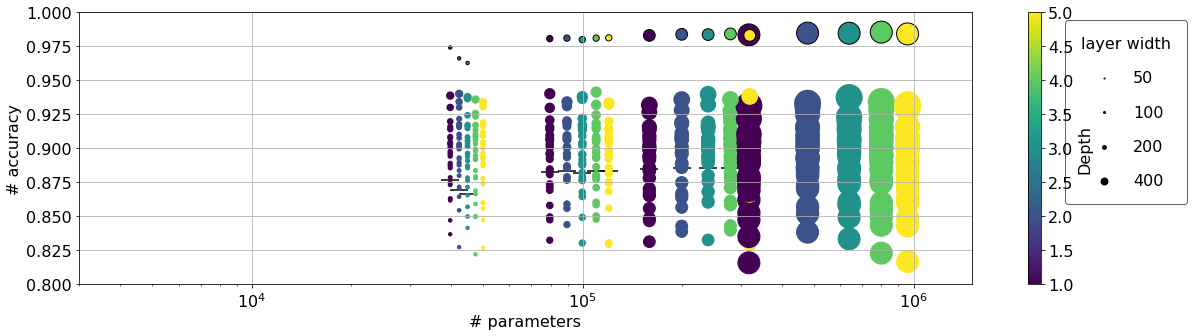

In [24]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

plt.figure(figsize=(20,5.0))

for i in range(acc_test_all.shape[2]):
    acc = acc_test_all[:,:,i].reshape(len(depth)*len(width),order='F')
    if i==0:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, edgecolors='k') 
        plt.scatter(fig_params_1d, 0.9*acc, marker="_", s=300, c='k', edgecolors='r') 
    else:
        plt.scatter(fig_params_1d, acc, s=(np.array(fig_width)**1.8)/100, c=fig_depth, facecolors='None', linewidth=np.array(dim[i])/300.0) 

        
ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.8, 1.0)
ax.set_xlim(0.3E4, 1.5E6)

plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/1000, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, loc='best', bbox_to_anchor=(1.25, 1),
             frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

 
    

#### Testing Accuracy of Intrinsic dim for #parameters

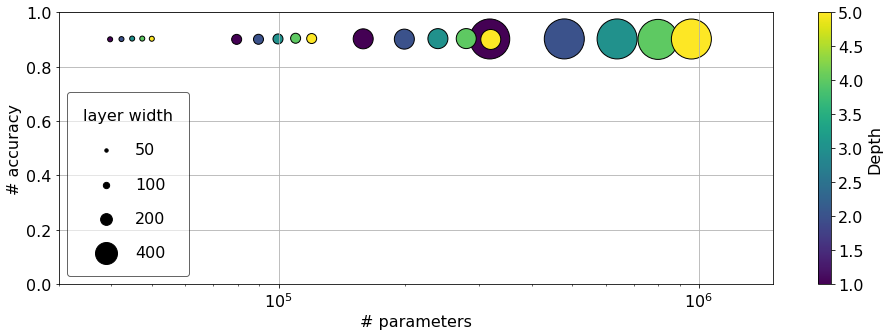

In [25]:
fig = plt.figure(figsize=(16,5))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.scatter(fig_params_1d, acc_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')
ax.grid(True)

ax.set_ylim(0.0, 1.0)
ax.set_xlim(0.3E5, 1.5E6)


plt.xlabel('# parameters')
plt.ylabel('# accuracy')

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w")

#### Intrinsic dim for #parameters

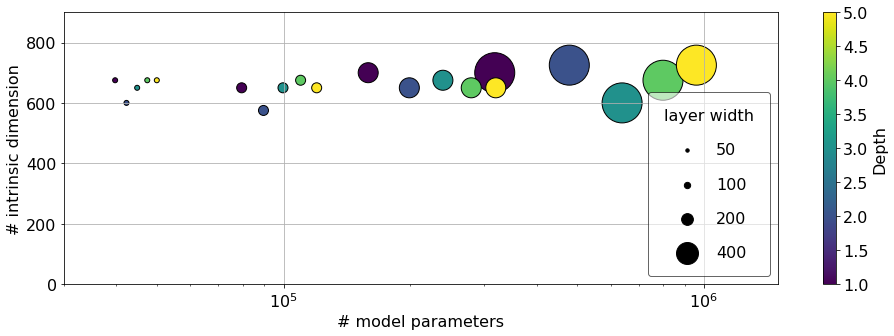

In [27]:
fig = plt.figure(figsize=(16,5))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

plt.scatter(fig_params_1d, dim_solved_all_1d, s=(np.array(fig_width)**2.0)/100, c=fig_depth, edgecolors='k') 

ax = plt.gca()
plt.colorbar(label="Depth")

ax.set_xscale('log')

ax.grid(True)
ax.set_ylim(0, 900)

plt.xlabel('# model parameters')
plt.ylabel('# intrinsic dimension')
ax.set_xlim(0.3E5, 1.5E6)

#make a legend:
pws = width
for pw in pws:
    plt.scatter([], [], s=(pw**1.8)/100, c="k",label=str(pw))

h, l = plt.gca().get_legend_handles_labels()
plt.legend(h[0:], l[0:], labelspacing=1.2, title="layer width", borderpad=1, 
            frameon=True, framealpha=0.6, edgecolor="k", facecolor="w",loc='best')

fig.savefig("fnn_dim_global_ni.pdf", bbox_inches='tight')

## Performance comparison with Baseline

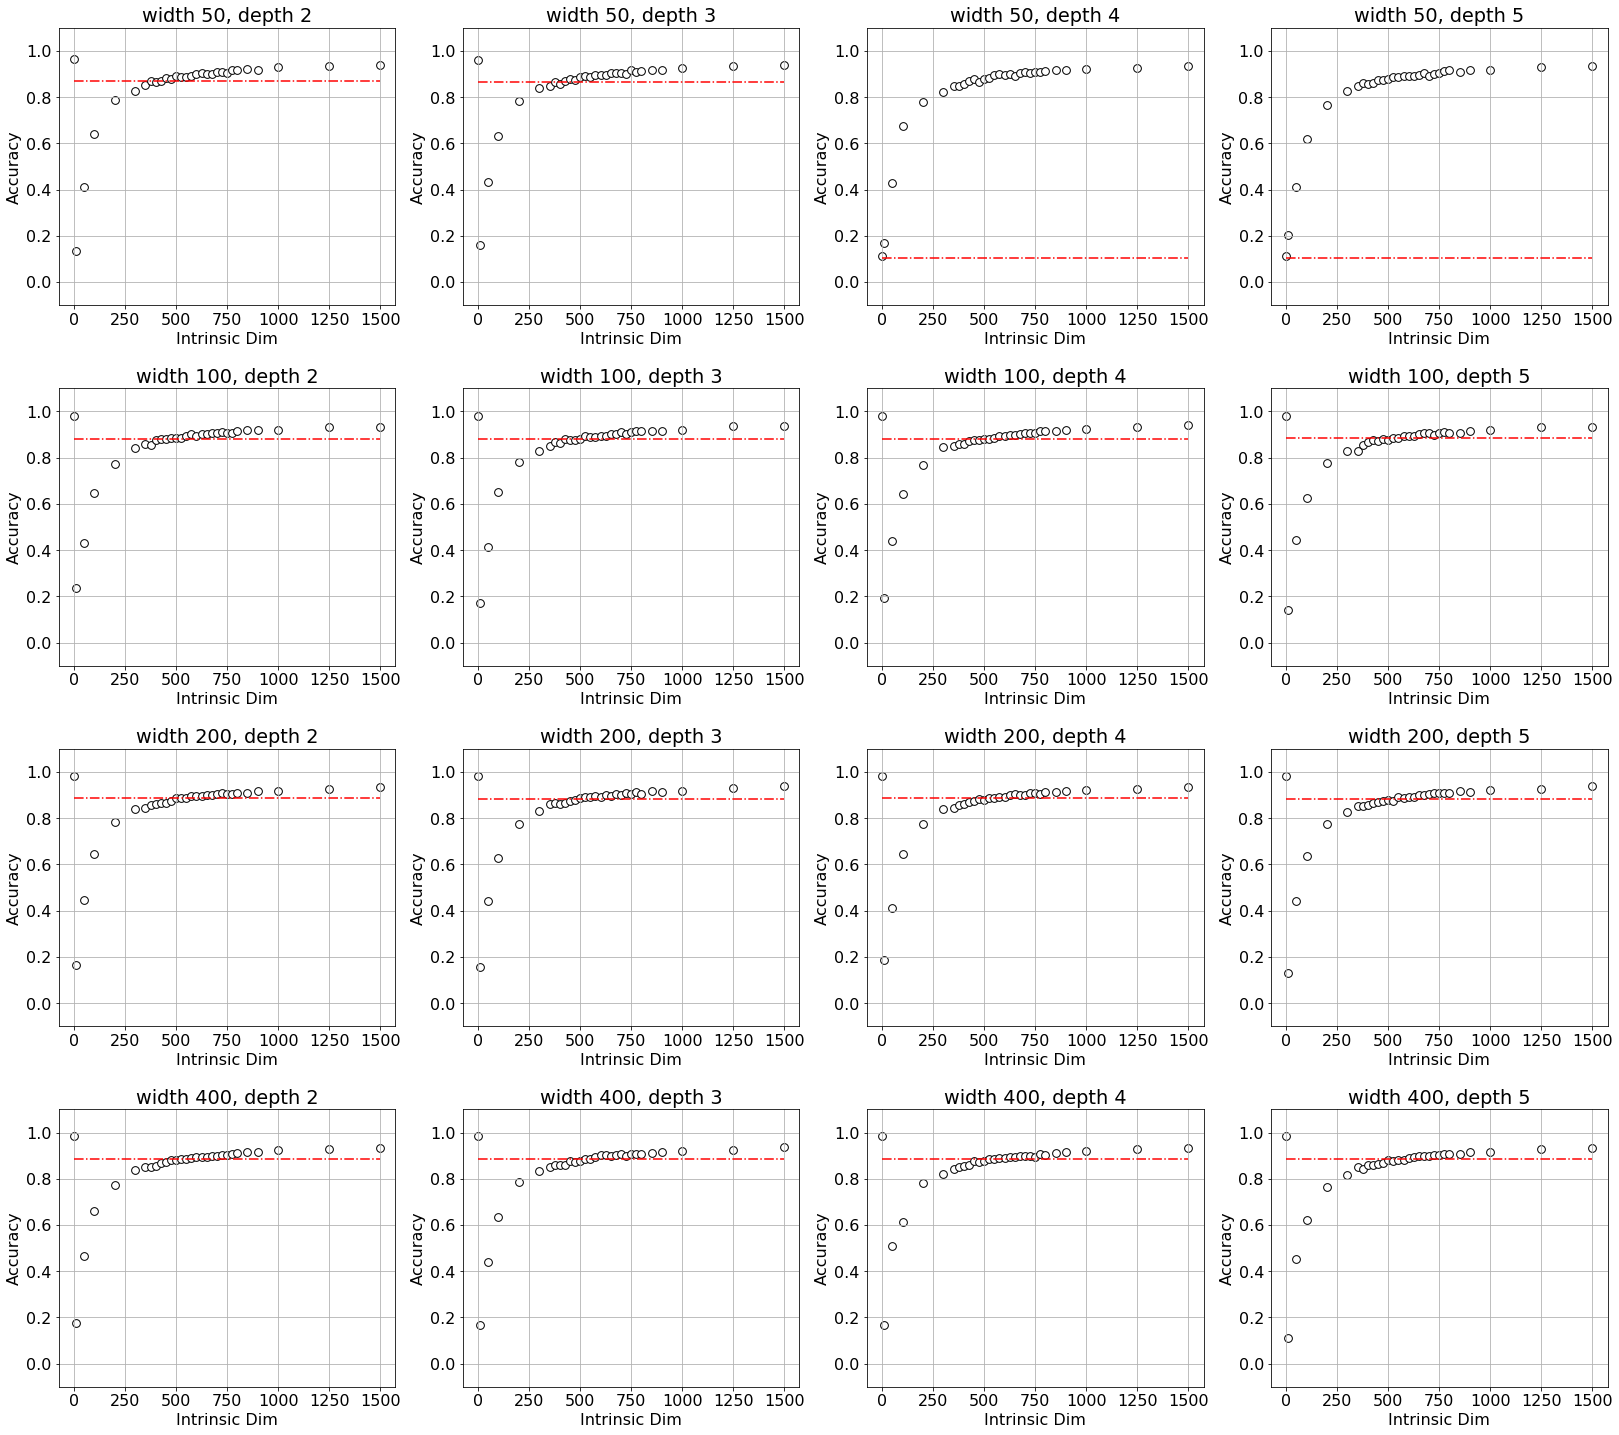

In [22]:
fig = plt.figure(figsize=(35,25))
fig.subplots_adjust(hspace=0.3)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

for i in range(nw):
    for j in range(nd):
        if j>0:
            id = i*nd+j+1
            ax = plt.subplot(nw, nd, id)

            plt.scatter(dim, acc_test_all[i,j,:], edgecolor="k", facecolor="w", s=60 )
            ax.plot(dim, acc_test_all[i,j,0]*np.ones(nn)*0.9,'r-.', label="Testing: baseline")
            ax.set_xlabel('Intrinsic Dim')
            ax.set_ylabel('Accuracy')
            ax.set_title('width %d, depth %d' %(width[i], depth[j]))
            plt.grid()
            ax.set_ylim([-0.1,1.1])

fig.savefig("fnn_all_configs_ni.pdf", bbox_inches='tight')

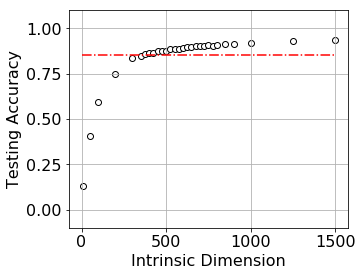

In [34]:
fig = plt.figure(figsize=(35,18))
fig, ax = subplots(figsize=(5,4))

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

sr = acc_test_all[0,0,0]*0.9

plt.scatter(dim[1:], acc_test_all[0,0,1:], edgecolor="k", facecolor="w" )
ax.plot(dim, acc_test_all[0,0,0]*np.ones(nn)*sr,'r-.', label="Testing: baseline")
ax.set_xlabel('Intrinsic Dimension')
ax.set_ylabel('Testing Accuracy')
# ax.set_title('width %d, depth %d' %(width[i], depth[j]))
plt.grid()
ax.set_ylim([-0.1,1.1])
# fig.set_size_inches(5, 4)
        
fig.savefig("fnn_mnist_ni.pdf", bbox_inches='tight')        


In [35]:
acc_test_all.shape

(4, 5, 30)